In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)
np.random.seed(1)

In [2]:
def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:]==0,0], X[y[:]==0,1], 'ro', label='y=0')
    plt.plot(X[y[:]==1,0], X[y[:]==1,1], 'go', label='y=1')
    plt.plot(X[y[:]==2,0], X[y[:]==2,1], 'o', label='y=2')
    plt.title('Decision Region')
    plt.legend()

In [3]:
class Data(Dataset):
    def __init__(self, K=3, N=500):
        D = 2
        # data matrix (each row = single example)
        X = np.zeros((N * K, D)) 
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
            ix = range(N * j, N * (j + 1))
            r = np.linspace(0.0, 1, N) # radius
            t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
            X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
            y[ix] = j    
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
            
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len
    
    def plot_data(self):
        plt.plot(
            self.x[self.y[:] == 0, 0].numpy(), 
            self.x[self.y[:] == 0, 1].numpy(), 
            'o', 
            label='y = 0')
        plt.plot(
            self.x[self.y[:] == 1, 0].numpy(),
            self.x[self.y[:] == 1, 1].numpy(),
            'ro',
            label='y = 1')
        plt.plot(
            self.x[self.y[:] == 2, 0].numpy(),
            self.x[self.y[:] == 2, 1].numpy(), 
            'go',
            label='y = 2')
        plt.legend()

In [4]:
class Net(nn.Module):
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = F.relu(linear_transform(x))    
            else:
                x = linear_transform(x)
        return x

In [5]:
def train(
        data_set, model, criterion, train_loader, optimizer, epochs=100
):
    losses = []
    acc = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        acc.append(accuracy(model,data_set))
    results = {'Loss': losses, 'Accuracy': acc}
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(losses, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(acc, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()
    plt.show()
    return results

In [6]:
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

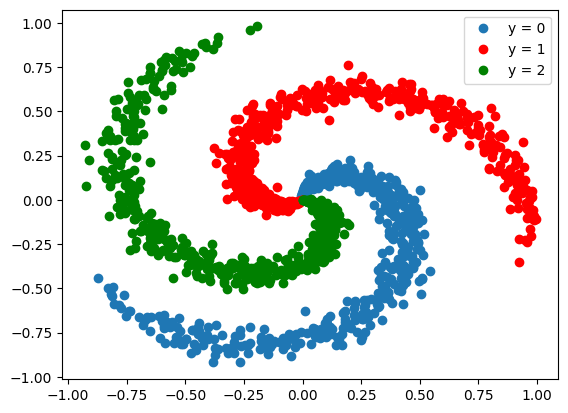

In [7]:
data_set = Data()
data_set.plot_data()
data_set.y = data_set.y.view(-1)

In [8]:
results = {
    'momentum 0': {'Loss': 0, 'Accuracy': 0}, 
    'momentum 0.1': {'Loss': 0, 'Accuracy': 0}}

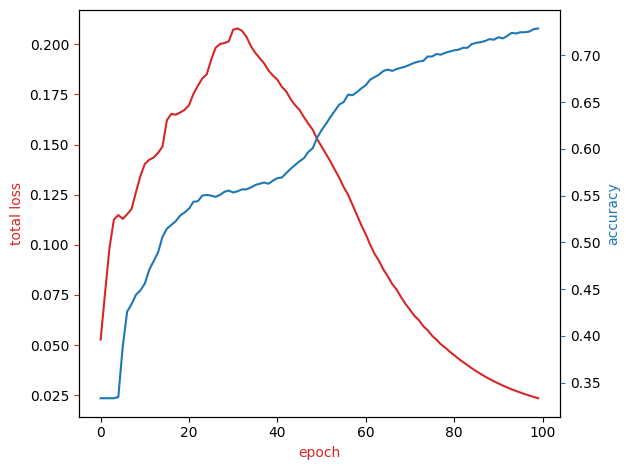

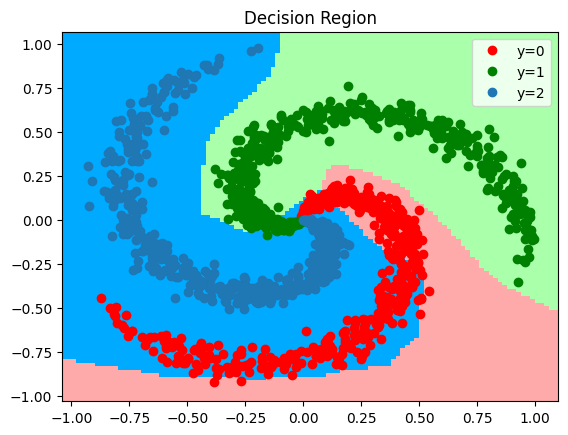

In [9]:
layers = [2, 50, 3]
model = Net(layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
results['momentum 0'] = train(
    data_set, model, criterion, train_loader, optimizer, epochs=100)
# Prints the dataset and decision boundaries
plot_decision_regions_3class(model, data_set)

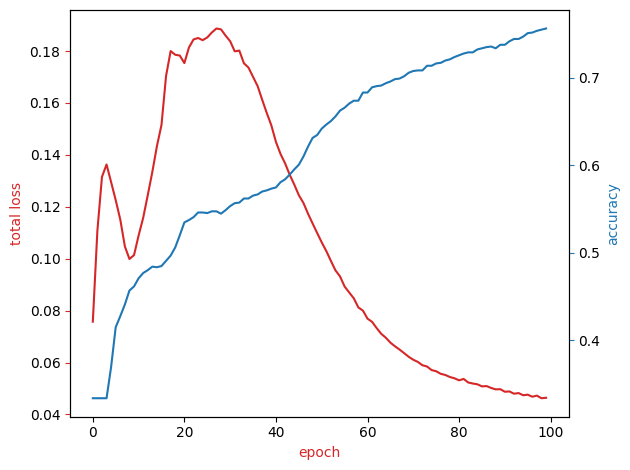

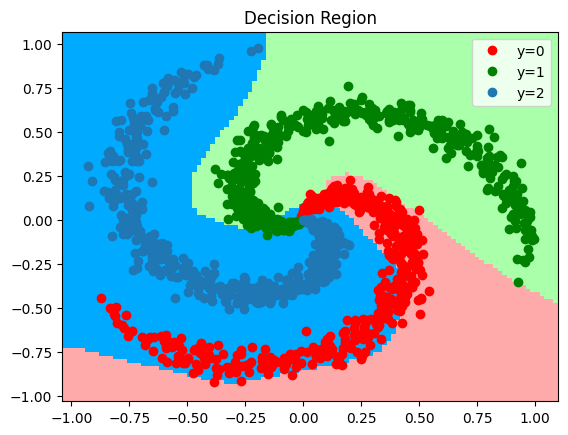

In [10]:
layers = [2, 50, 3]
model = Net(layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.1)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
results['momentum 0.1'] = train(
    data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

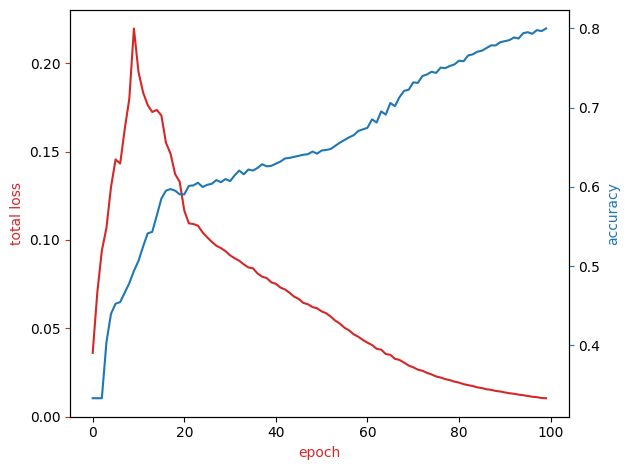

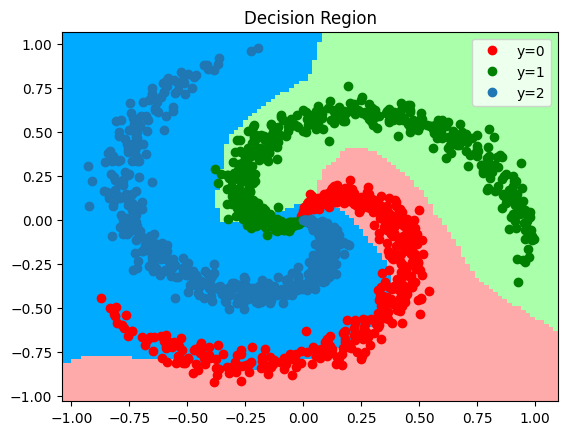

In [11]:
layers = [2, 50, 3]
model = Net(layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.2)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
results['momentum 0.2'] = train(
    data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

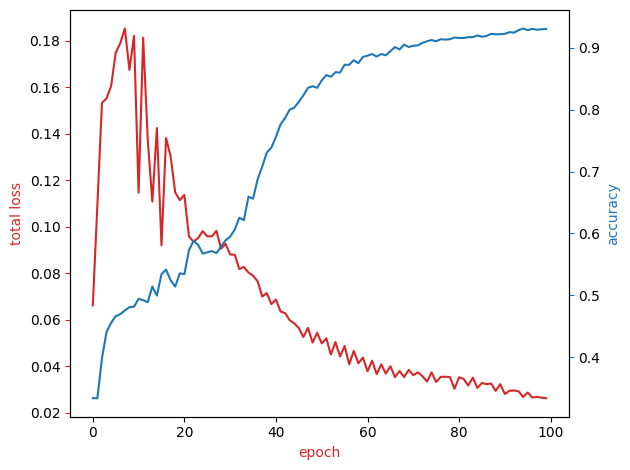

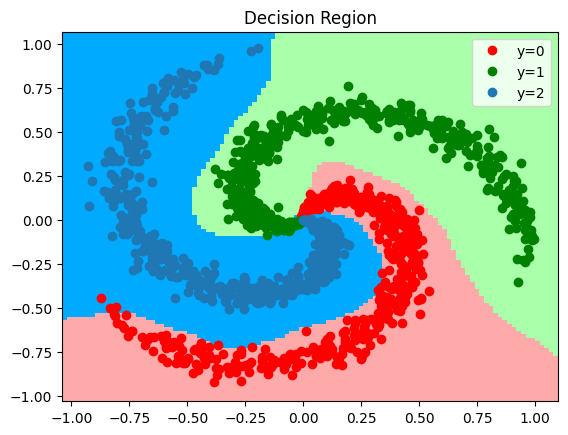

In [12]:
layers = [2, 50, 3]
model = Net(layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.4)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
results['momentum 0.4'] = train(
    data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

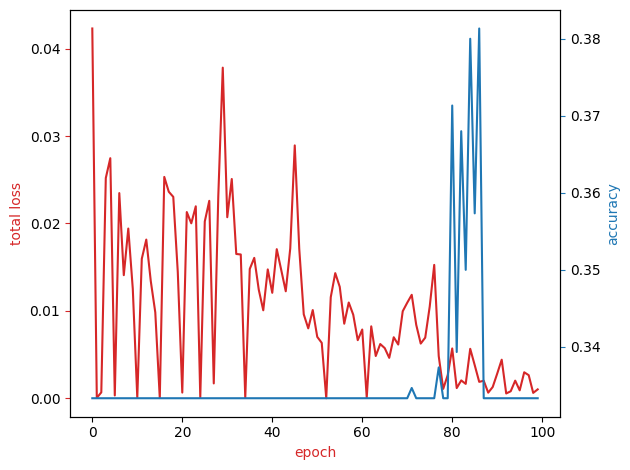

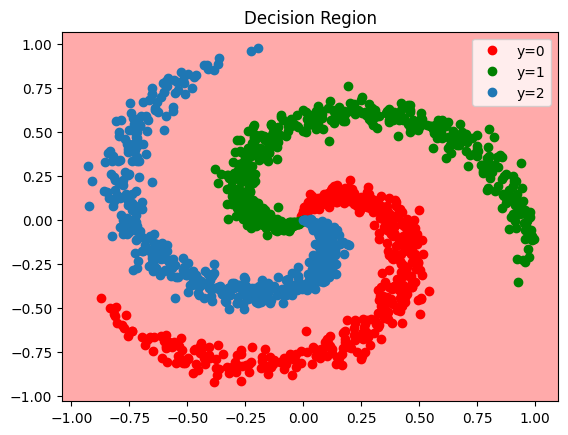

In [13]:
layers = [2, 50, 3]
model = Net(layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.8)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
results['momentum 0.8'] = train(
    data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

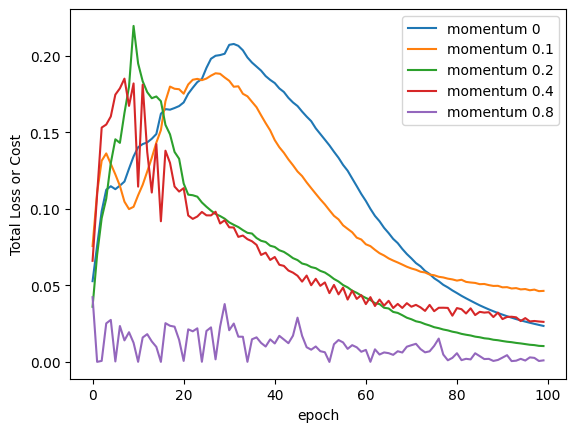

In [14]:
for k, v in results.items():
    plt.plot(v['Loss'], label=k)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

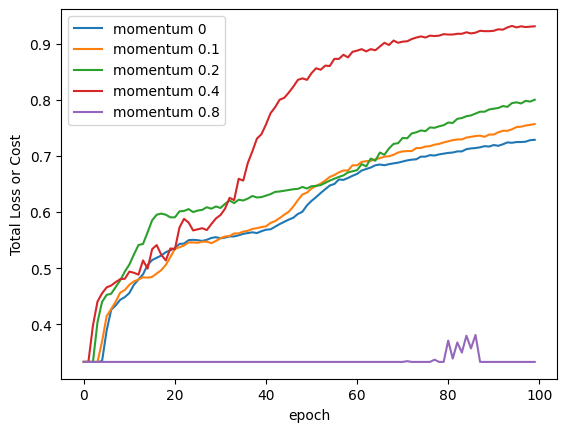

In [15]:
for k, v in results.items():
    plt.plot(v['Accuracy'], label=k)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')